# 1. Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from IPython.display import display
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path

# 2. Load data 

In [2]:
train_df = pd.read_csv('./data/train.csv').drop(columns=['id'])
test_df = pd.read_csv('./data/test.csv')
FEATURES = train_df.columns[:-1]
TARGET = train_df.columns[-1]
print(train_df.shape)
print(test_df.shape)

(42100, 18)
(28068, 18)


# 3. EDA

In [3]:
# Describe dataset
train_df[FEATURES].describe().T.sort_values(by='std', ascending=False)\
    .style.background_gradient(cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
lead_time,42100.000000,103.888029,81.069343,0.000000,37.000000,93.000000,155.000000,443.000000
avg_price_per_room,42100.000000,104.566377,37.139165,0.000000,80.000000,99.450000,123.300000,540.000000
arrival_date,42100.000000,15.902945,8.888582,1.000000,8.000000,16.000000,24.000000,31.000000
arrival_month,42100.000000,7.593539,2.829395,1.000000,6.000000,8.000000,10.000000,12.000000
no_of_previous_bookings_not_canceled,42100.000000,0.175772,1.732121,0.000000,0.000000,0.000000,0.000000,58.000000
no_of_week_nights,42100.000000,2.398005,1.427330,0.000000,1.000000,2.000000,3.000000,17.000000
no_of_weekend_nights,42100.000000,0.884632,0.885693,0.000000,0.000000,1.000000,2.000000,7.000000
room_type_reserved,42100.000000,0.428931,0.832605,0.000000,0.000000,0.000000,1.000000,6.000000
no_of_special_requests,42100.000000,0.571734,0.775041,0.000000,0.000000,0.000000,1.000000,5.000000
market_segment_type,42100.000000,0.728504,0.633529,0.000000,0.000000,1.000000,1.000000,4.000000


In [ ]:
# Check for duplicates 

train_df[[col for col in train_df.columns if col != 'booking_status']].duplicated().sum()

In [168]:
test_df.drop(columns=['id']).duplicated().sum()

253

In [174]:
train_df[train_df[[col for col in train_df.columns if col != 'booking_status']].duplicated()]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,arrival_month_year,arrival_year_month_date,week
1870,1,0,0,2,2,0,0,377,2018,10,...,0,0,0,0,90.00,0,0,2018-10-01,2018-10-14,41.0
2477,2,0,2,0,0,0,0,275,2018,4,...,0,0,0,0,110.00,0,1,2018-04-01,2018-04-17,16.0
3685,2,0,1,2,0,0,0,224,2017,10,...,0,0,0,0,65.00,0,0,2017-10-01,2017-10-02,40.0
4025,2,0,0,5,0,0,0,230,2018,9,...,1,0,0,0,137.00,0,0,2018-09-01,2018-09-06,36.0
4070,2,0,0,4,0,0,1,213,2018,8,...,1,0,0,0,118.15,1,1,2018-08-01,2018-08-31,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42045,2,0,2,3,0,0,0,118,2018,4,...,1,0,0,0,90.95,0,1,2018-04-01,2018-04-10,15.0
42050,2,0,0,2,0,0,0,322,2018,12,...,0,0,0,0,52.00,0,0,2018-12-01,2018-12-09,49.0
42071,2,0,0,2,2,0,0,257,2018,7,...,0,0,0,0,101.50,0,0,2018-07-01,2018-07-01,26.0
42077,2,0,0,1,0,0,0,131,2018,7,...,1,0,0,0,105.30,1,0,2018-07-01,2018-07-23,30.0


In [4]:
# Check the type of variables that dataset has

for col in train_df[FEATURES]: 
    print(train_df[col].value_counts())

2    30771
1     7089
3     4061
0      167
4       12
Name: no_of_adults, dtype: int64
0    37786
1     2729
2     1561
3       17
4        5
9        2
Name: no_of_children, dtype: int64
0    18137
2    12143
1    11389
3      239
4      128
5       46
6       17
7        1
Name: no_of_weekend_nights, dtype: int64
2     12905
3     10286
1      9558
4      4175
5      2573
0      1937
6       237
7       160
8        84
10       82
9        53
11       16
15       11
12        9
13        5
16        4
14        3
17        2
Name: no_of_week_nights, dtype: int64
0    35463
2     3421
1     3210
3        6
Name: type_of_meal_plan, dtype: int64
0    41037
1     1063
Name: required_car_parking_space, dtype: int64
0    29853
1     9135
3     1465
2     1131
4      320
5      190
6        6
Name: room_type_reserved, dtype: int64
1      846
0      827
2      502
6      498
3      480
      ... 
326      1
353      1
300      1
325      1
348      1
Name: lead_time, Length: 338, dtype: int

## 3.1. Categorical & Continuous variables

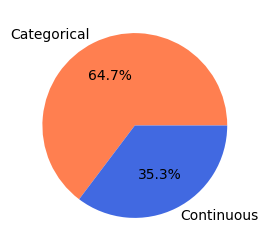

In [5]:
# Select categorical and continuous variables: 
# I will set categorical variables to the ones with less than 10 categories
categorical_features = []
continuous_features = []

for col in FEATURES: 
    if train_df[col].nunique() <=10: 
        categorical_features.append(col)
    else: 
        continuous_features.append(col) 


fig = plt.figure(figsize=(6,3))
plt.pie(
    [len(categorical_features), len(continuous_features)],
    labels = ['Categorical', 'Continuous'], 
    colors=['coral','royalblue'], 
    autopct='%1.1f%%'
)
plt.show()

## 3.2. Visualize continuous variables

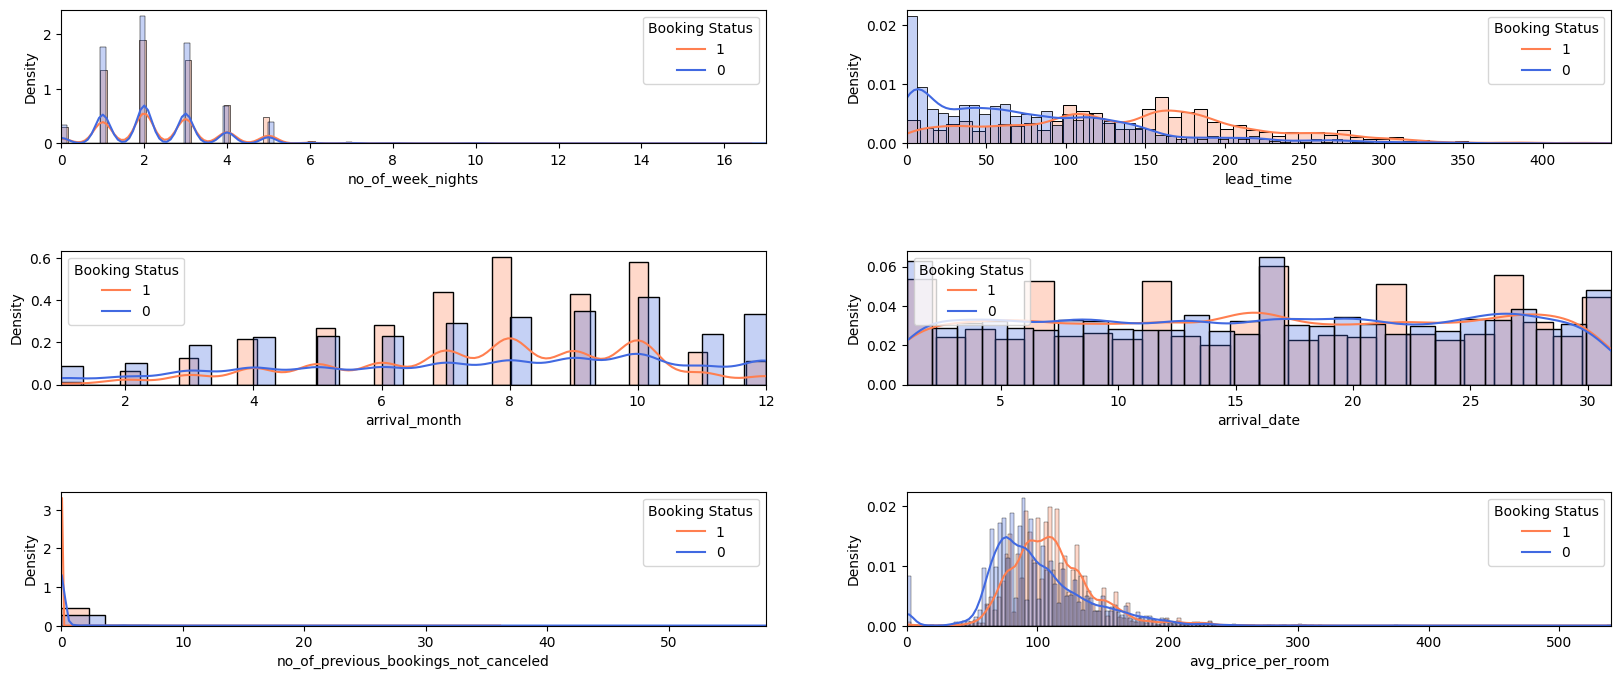

In [129]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
for r in range(nrows):
    for c in range(ncols):
        col = np.array(continuous_features).reshape(3,2)[r,c]
        col = continuous_features[r*ncols+c]

        sns.kdeplot(train_df[train_df[TARGET]==1][col], label=1, ax = axes[r,c], color='coral')
        sns.histplot(train_df[train_df[TARGET]==1][col], color='coral', alpha = 0.3, stat='density', ax = axes[r,c])
        
        sns.kdeplot(train_df[train_df[TARGET]==0][col], label = 0, ax = axes[r,c], color = 'royalblue')
        sns.histplot(train_df[train_df[TARGET]==0][col], color='royalblue', alpha = 0.3, stat='density', ax = axes[r,c])
        min_f = train_df[col].min()
        max_f = train_df[col].max()
        axes[r,c].legend(title='Booking Status')
        axes[r,c].set_xlim([min_f, max_f])


- Looking at the data we can see that lead_time > 150 tend to booking canceled = 1  while the others < 150 tend to 0.
- Avg_price_per_room > 100 tend to be cancelled more than kept. 
- In summer months: June, July, August, Sept and Oct there's a higher chance to cancel.

## 3.3. Visualize categorical data 

<Figure size 640x480 with 0 Axes>

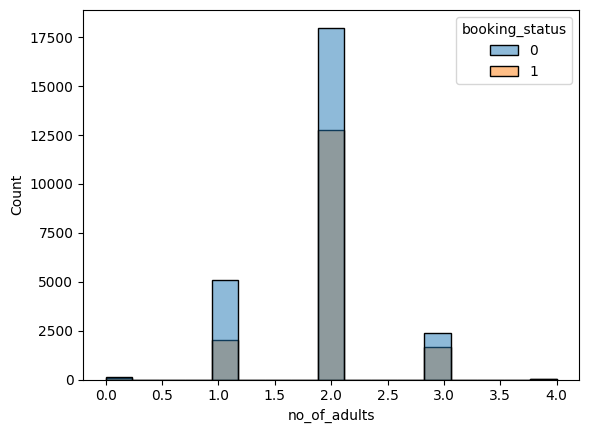

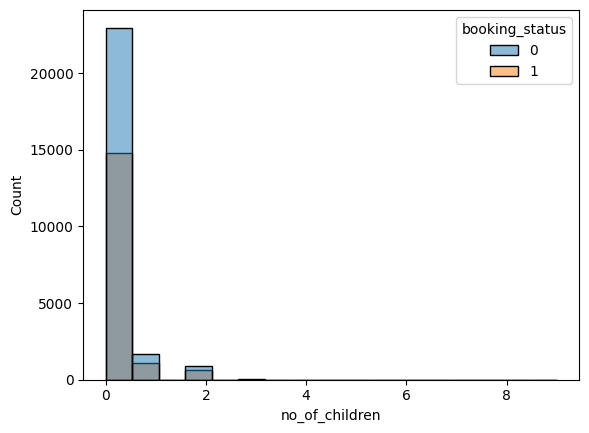

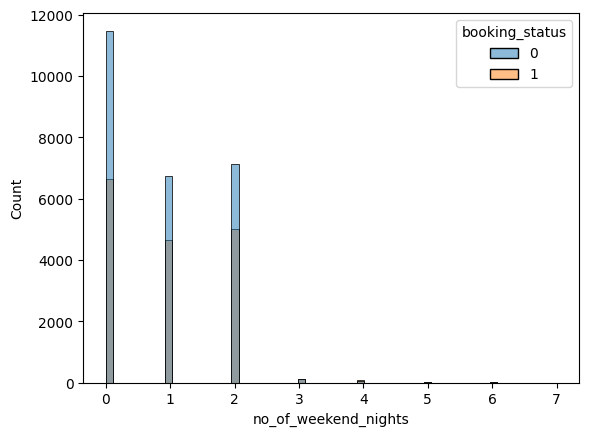

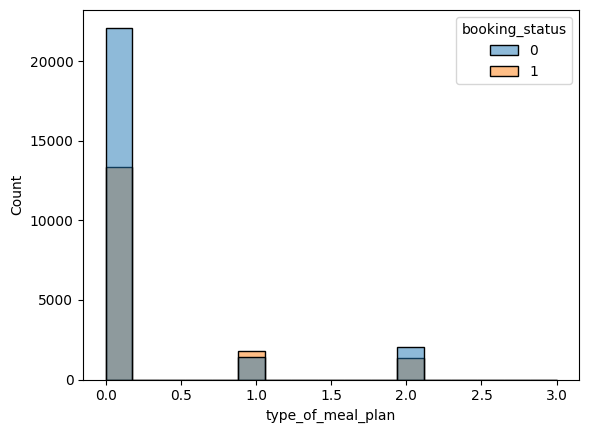

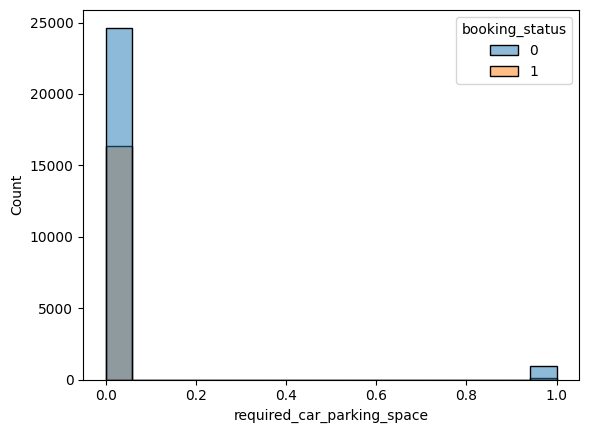

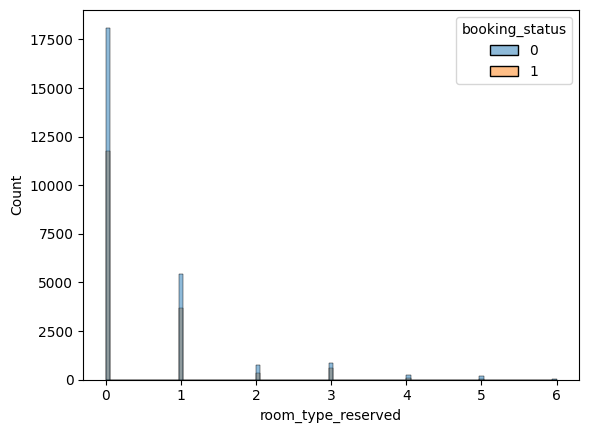

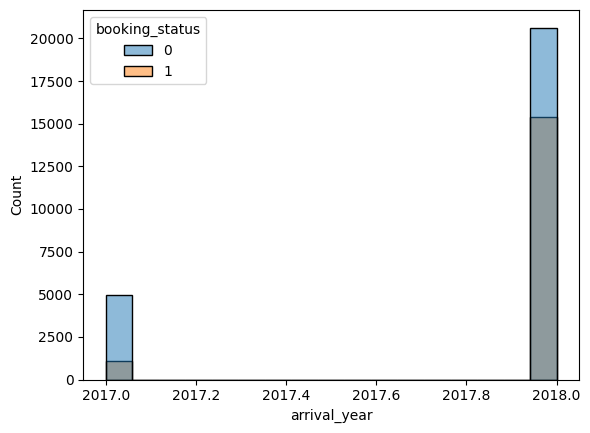

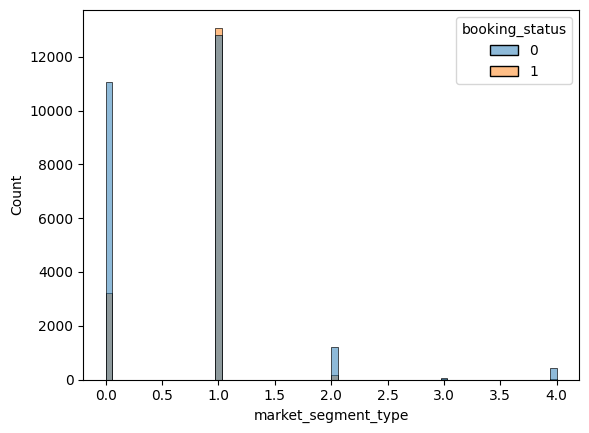

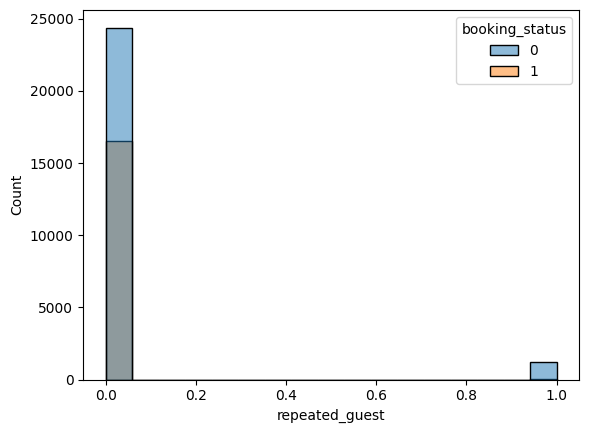

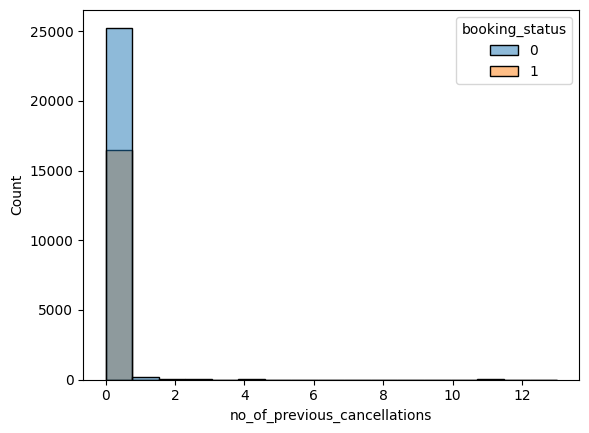

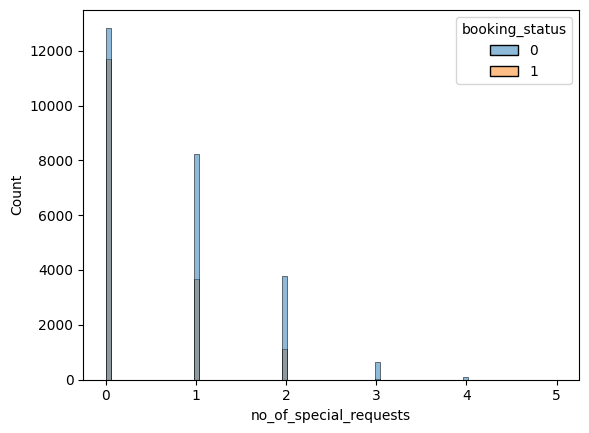

In [7]:
plt.subplots_adjust(hspace=0.8)
#fig, axes = plt.subplots(11, 1, figsize=(10,30))
plt.subplots_adjust(hspace=0.8)
i = 0

plt.figure()
for col in categorical_features: 
    sns.histplot(data = train_df , x = col, hue = TARGET)
    plt.show()

Looking at categorical data we can extract the following: 
- People without previous cancelations tend to not cancel a book 
- People with 1 or more special requests tend to not cancel a book. 
- Required parking space tend to not cancel a book 
- People without children tend to not cancel books
- 1-2 adults tend to not cancel books. 
- Plans that involve 0-3 weekend night tend to not being cancelled. 


## 3.4. TimeSeries 

In [102]:
# 2017 and 2018 are not "año bisiesto". Replace arrival date > 28 by 28. 
train_df.loc[(train_df['arrival_month']==2) & (train_df['arrival_date']>28),'arrival_date'] = str(28)

In [117]:
train_df['arrival_year_month_date'] = pd.to_datetime(train_df['arrival_year'].astype(str)+'/'+train_df['arrival_month'].astype(str)+'/'+train_df['arrival_date'].astype(str), format="%Y/%m/%d",errors='coerce')

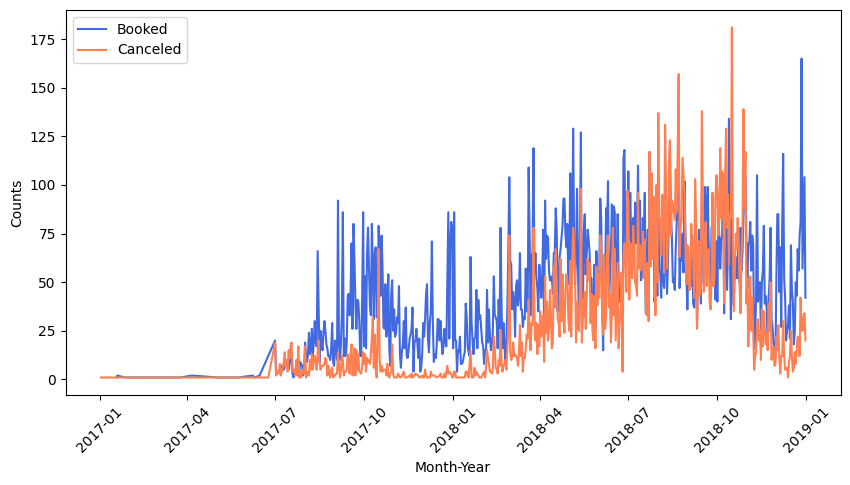

In [130]:
plt.figure(figsize=(10,5))
sns.lineplot(train_df[train_df[TARGET]==0]['arrival_year_month_date'].value_counts(), label = 'Booked', color='royalblue')
sns.lineplot(train_df[train_df[TARGET]==1]['arrival_year_month_date'].value_counts(), label = 'Canceled', color='coral')
plt.xlabel('Month-Year')
plt.ylabel('Counts')
plt.xticks(rotation = 45)
plt.legend()

In [137]:
# Group by week 
train_df['week'] = train_df['arrival_year_month_date'].dt.isocalendar().week.astype(float)

564

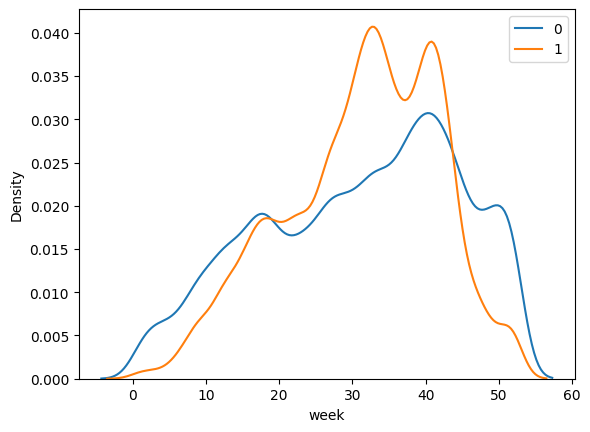

In [154]:
sns.kdeplot(train_df[train_df[TARGET]==0]['week'], label=0)
sns.kdeplot(train_df[train_df[TARGET]==1]['week'], label=1)
plt.legend()

## 3.5. Correlation matrix 

<AxesSubplot:>

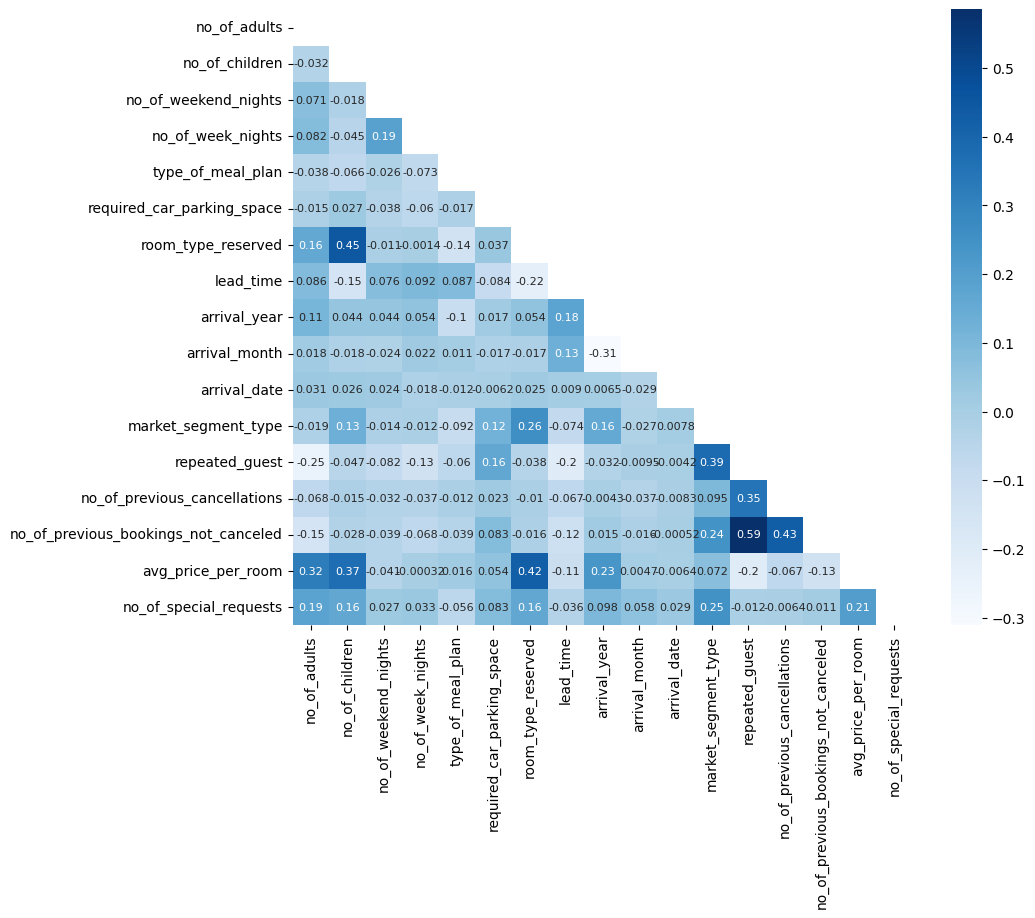

In [14]:
mask = np.zeros_like(train_df[FEATURES].corr(), dtype='bool')
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(train_df[FEATURES].corr(), mask = mask, cmap= 'Blues', annot = True, annot_kws={"size":8}, )

### 4. Model baseline 

In [11]:
# Decision Trees and Random Forest do not require feature scaling. 
# I am going to try several models

skf = StratifiedKFold(n_splits = 5, shuffle = True)
lgb_scores = []
xgb_scores = []
fim_dfs = []
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df[FEATURES], train_df[TARGET])): 
    X_train, X_valid = train_df[FEATURES].iloc[train_idx], train_df[FEATURES].iloc[valid_idx]
    y_train, y_valid = train_df[TARGET].iloc[train_idx], train_df[TARGET].iloc[valid_idx]

    lgbm = LGBMClassifier(objective='binary', metric = 'auc', n_estimators=100)
    xgb = XGBClassifier(objective='binary:logistic', n_estimators = 100)

    lgbm.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    lgb_scores.append(roc_auc_score(y_valid, lgbm.predict_proba(X_valid)[:,1]))
    xgb_scores.append(roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:,1]))



    fim = pd.DataFrame(index = FEATURES, 
    data = {
        f'lgbm_{fold}_importance': lgbm.feature_importances_, 
        f'xgb_{fold}_importance': xgb.feature_importances_
        })

    fim_dfs.append(fim)    
print(f'Mean AUC LGBM: {np.array(lgb_scores).mean()}')
print(f'Mean AUC XGBoost {np.array(xgb_scores).mean()}')

Mean AUC LGBM: 0.8950720847306736
Mean AUC XGBoost 0.8958847837641203


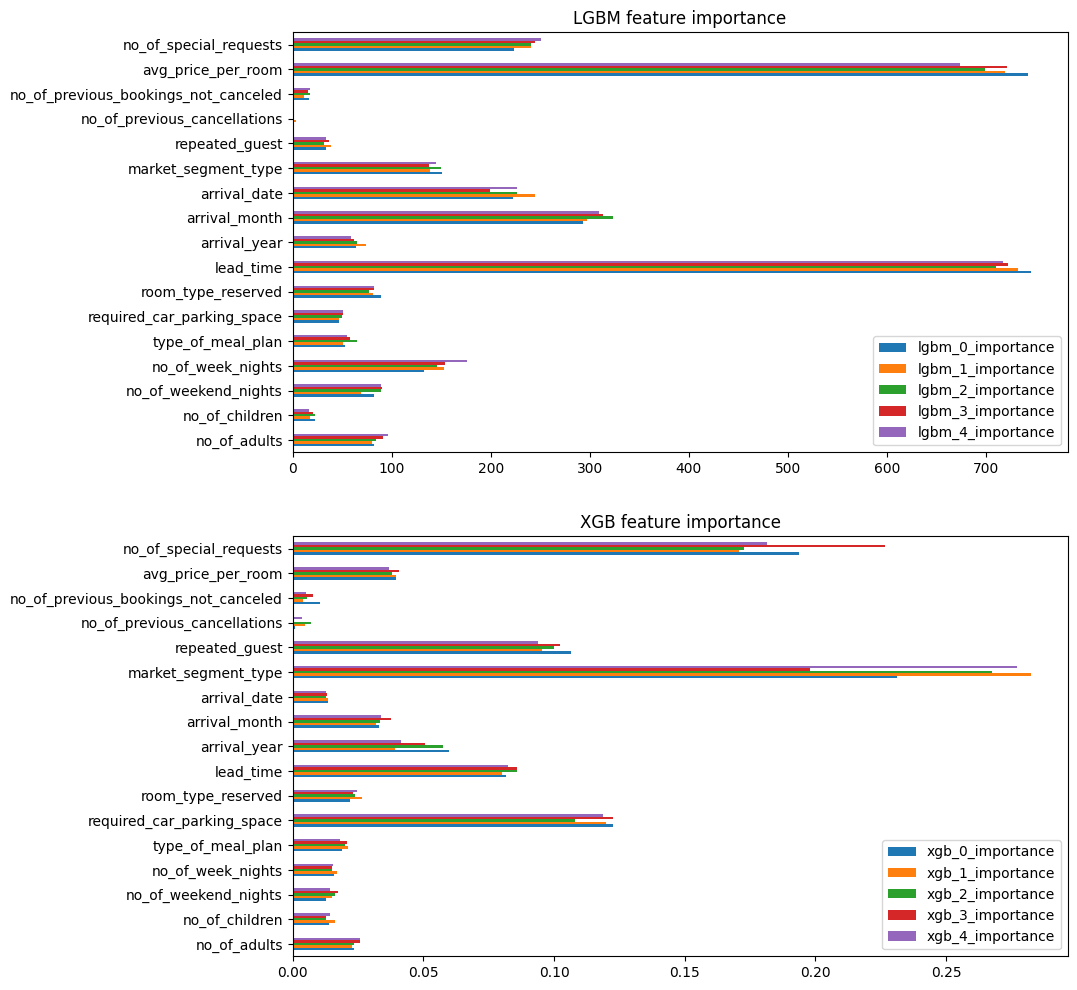

In [13]:
fig, axs = plt.subplots(2,1, figsize= (15,18))
fims = pd.concat(fim_dfs, axis=1)
axs[0] = fims[fims.columns[fims.columns.isin('lgbm_'+str(i)+'_importance' for i in range(0,5))]].plot(kind='barh', figsize=(10,12), title='LGBM feature importance', ax = axs[0])
axs[1] = fims[fims.columns[fims.columns.isin('xgb_'+str(i)+'_importance' for i in range(0,5))]].plot(kind='barh', figsize=(10,12), title='XGB feature importance', ax= axs[1])


# 5. Model test predictions 


In [18]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators = 100)
xgb.fit(train_df[FEATURES], train_df[TARGET])
preds = xgb.predict(test_df[FEATURES])
pd.DataFrame({'id': pd.read_csv('./data/sample_submission.csv')['id'], 'booking_status' : preds}).to_csv('./data/results_1.csv', index=False)

In [19]:
pd.read_csv('./data/results_1.csv')

,id,booking_status
0,42100,0
1,42101,0
2,42102,0
3,42103,0
4,42104,0
...,...,...
28063,70163,1
28064,70164,0
28065,70165,0
28066,70166,0
